In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense

model_name = "PE_classification_224_160_48_1_1_e.h5"

# Folder "nr_128_64" consist of CT scans having normal lung tissue or other lung disease

normal_scan_paths2 = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE0415/val/nr", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/val/nr")
]
# Folder "pe_128_64" consist of CT scans having Pulmonary embolism,

abnormal_scan_paths2 = [
    os.path.join(os.getcwd(),"C:/Users/85298/AI/PE0415/val/pe", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/val/pe")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths2)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths2)))


####################################################

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
#   Read and load volume
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


abnormal_scans2 = np.array([read_nifti_file(path) for path in abnormal_scan_paths2])
normal_scans2 = np.array([read_nifti_file(path) for path in normal_scan_paths2])

nr100 = round(len(normal_scan_paths2)  )
pe100 = round(len(abnormal_scan_paths2)   )


#print("nr70%:",nr70,"nr30%",nr30)
#print("pe70%:",pe70,"pe30%:",pe30)

# For the CT scans having Pulmonary embolism
# assign 1, for the normal and other disease ones assign 0.
abnormal_labels2 = np.array([1 for _ in range(len(abnormal_scans2))])
normal_labels2 = np.array([0 for _ in range(len(normal_scans2))])

# Split data in the ratio 70-30 for training and validation.
x_train2 = np.concatenate((abnormal_scans2[:pe100], normal_scans2[:nr100]), axis=0)
y_train2 = np.concatenate((abnormal_labels2[:pe100], normal_labels2[:nr100]), axis=0)
x_val2 = np.concatenate((abnormal_scans2[pe100:], normal_scans2[nr100:]), axis=0)
y_val2 = np.concatenate((abnormal_labels2[pe100:], normal_labels2[nr100:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train2.shape[0], x_val2.shape[0])
)


CT scans with normal lung tissue: 32
CT scans with abnormal lung tissue: 8
Number of samples in train and validation are 40 and 0.


In [2]:
from keras.utils import np_utils
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, SGD
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from keras.models import Model
import cv2
import time
import os
import numpy as np
import keras
import h5py
import numpy as np
from keras import regularizers
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model
import keras
import tensorflow as tf

def get_model():
    
    input_layer = Input((224, 160, 48, 1))
    
    conv_layer1 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu')(input_layer)
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)
    pooling_layer1 = BatchNormalization()(pooling_layer1) 
    
    
    conv_layer2 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
    pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
    pooling_layer2 = BatchNormalization()(pooling_layer2)  

    
    conv_layer3 = Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu')(pooling_layer2)
    pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer3)
    pooling_layer3 = BatchNormalization()(pooling_layer3)

    
    conv_layer4 = Conv3D(filters=1024, kernel_size=(3, 3, 3), activation='relu')(pooling_layer3)
    pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
    pooling_layer4 = BatchNormalization()(pooling_layer4)

    
    flatten_layer = Flatten()(pooling_layer4)
    

    dense_layer4 = Dense(units=2048, activation='relu')( flatten_layer)
    dense_layer4 = Dropout(0.4)(dense_layer4)
    
    
    dense_layer5 = Dense(units=1024, activation='relu')(dense_layer4)
    dense_layer5 = Dropout(0.4)(dense_layer5)
    

    output_layer = Dense(units=1, activation="sigmoid")(dense_layer5)
    

    model = Model(inputs=input_layer, outputs=output_layer, name="3dcnn")

    
    return model

model = None
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 111, 79, 23, 128)  0        
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 79, 23, 128)  512      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 109, 77, 21, 256)  884992

In [3]:
import warnings 
warnings.simplefilter(action='ignore',category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd
import csv
from keras.models import load_model

df_label = pd.read_csv('C:/Users/85298/AI/CT_image/202304/label_cut_d.csv' , sep=',')
y=df_label.set_index("ID3", inplace = True)


df_out = pd.DataFrame(columns = ["ID","Disease","Label","predict", "actual"])
df_out2 = pd.DataFrame(columns = ["predict", "actual"])

len_nr = len(normal_scan_paths2)
len_pe = len(abnormal_scan_paths2)


for patient in range (0,len(y_train2)):

#for patient in range (0,20):
    
    if patient < len_pe:
    
        file_path = abnormal_scan_paths2[patient]
    
    else :
        
        file_path = normal_scan_paths2 [patient-len_pe]
        
    ID = file_path.split("_") [2]


    
    Disease = df_label.loc[int(ID)]["Disease"]    

    Label = df_label.loc[int(ID)]["Label"] 
    

    

# Load best weights.


    model.load_weights(model_name)
    prediction = model.predict(np.expand_dims(x_train2[patient], axis=0))[0]
    label_1 = y_train2[patient]
    
    scores = [1 - prediction[0], prediction[0]]
 #   print(label_1)
     
    prediction_score = round(prediction[0] *100,2)
    prediction_score2 = prediction[0] *100
        
    df_out = df_out.append({"ID": ID,"Disease":Disease,"Label":Label ,'predict' : prediction_score , 'actual' : label_1 },
        ignore_index = True)

    df_out2 = df_out2.append({'predict' : prediction_score2 , 'actual' : label_1 },
        ignore_index = True)
    
    
print(df_out)    


    
    

                
    
        




1/1 [==============================] - 0s 16ms/step
      ID                               Disease  Label  predict actual
0   4047            Pulmonary embolism present     PE    40.09      1
1   4051  Non-diagnostic of pulmonary embolism     PE    19.39      1
2   5016            Pulmonary embolism present     PE     4.39      1
3   6011                               Present     PE    18.17      1
4   6015                               Present     PE    89.49      1
5   6023                         Nondiagnostic     PE    43.32      1
6   6029                               Present     PE    47.96      1
7   6040                               Present     PE    52.59      1
8   1002                                    PH  OTHER    27.64      0
9   1005                                    PH  OTHER    19.23      0
10  1019    Chronic obstructive airway disease  OTHER    15.03      0
11  1025                                    PH  OTHER    17.16      0
12  2006                      Cancer c

In [4]:
import numpy as np
import pandas as pd
import csv
from keras.models import load_model

df_out = pd.read_csv('C:/Users/85298/AI/PE0415/AUC - 1.csv' , sep=',')

for i in np.arange (1,100,1):
    
    i = round(i,2)

    TP = 0
    FP = 0
    TN = 0
    FN = 0


    for patient in range (0,len(df_out)):
    

        if (df_out["predict"].iloc[patient] > i) & (df_out["actual"].iloc[patient] == 1) :
            TP = TP + 1
        if (df_out["predict"].iloc[patient] > i) & (df_out["actual"].iloc[patient] == 0) :
            FP = FP + 1
        if (df_out["predict"].iloc[patient] < i) & (df_out["actual"].iloc[patient] == 0) :
            TN = TN + 1
        if (df_out["predict"].iloc[patient] < i) & (df_out["actual"].iloc[patient] == 1) :
            FN = FN + 1        
        

    Precision = TP/(TP+FP)

    Recall = TP/(TP+FN)

    F1_score = ((Precision*Recall)/(Precision+Recall))*2

    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    print(str(i))
    print ("Precision",Precision,"Recall",Recall,"F1_score",F1_score,"Accuracy",Accuracy)
    print (TP,FP,TN,FN)           



1
Precision 0.21052631578947367 Recall 1.0 F1_score 0.34782608695652173 Accuracy 0.25
8 30 2 0
2
Precision 0.22857142857142856 Recall 1.0 F1_score 0.3720930232558139 Accuracy 0.325
8 27 5 0
3
Precision 0.22857142857142856 Recall 1.0 F1_score 0.3720930232558139 Accuracy 0.325
8 27 5 0
4
Precision 0.23529411764705882 Recall 1.0 F1_score 0.38095238095238093 Accuracy 0.35
8 26 6 0
5
Precision 0.22580645161290322 Recall 0.875 F1_score 0.358974358974359 Accuracy 0.375
7 24 8 1
6
Precision 0.23333333333333334 Recall 0.875 F1_score 0.3684210526315789 Accuracy 0.4
7 23 9 1
7
Precision 0.2413793103448276 Recall 0.875 F1_score 0.3783783783783784 Accuracy 0.425
7 22 10 1
8
Precision 0.25925925925925924 Recall 0.875 F1_score 0.39999999999999997 Accuracy 0.475
7 20 12 1
9
Precision 0.2692307692307692 Recall 0.875 F1_score 0.411764705882353 Accuracy 0.5
7 19 13 1
10
Precision 0.2692307692307692 Recall 0.875 F1_score 0.411764705882353 Accuracy 0.5
7 19 13 1
11
Precision 0.2692307692307692 Recall 0.875

ZeroDivisionError: division by zero

Text(0.5, 192.72222222222217, 'Predicted')

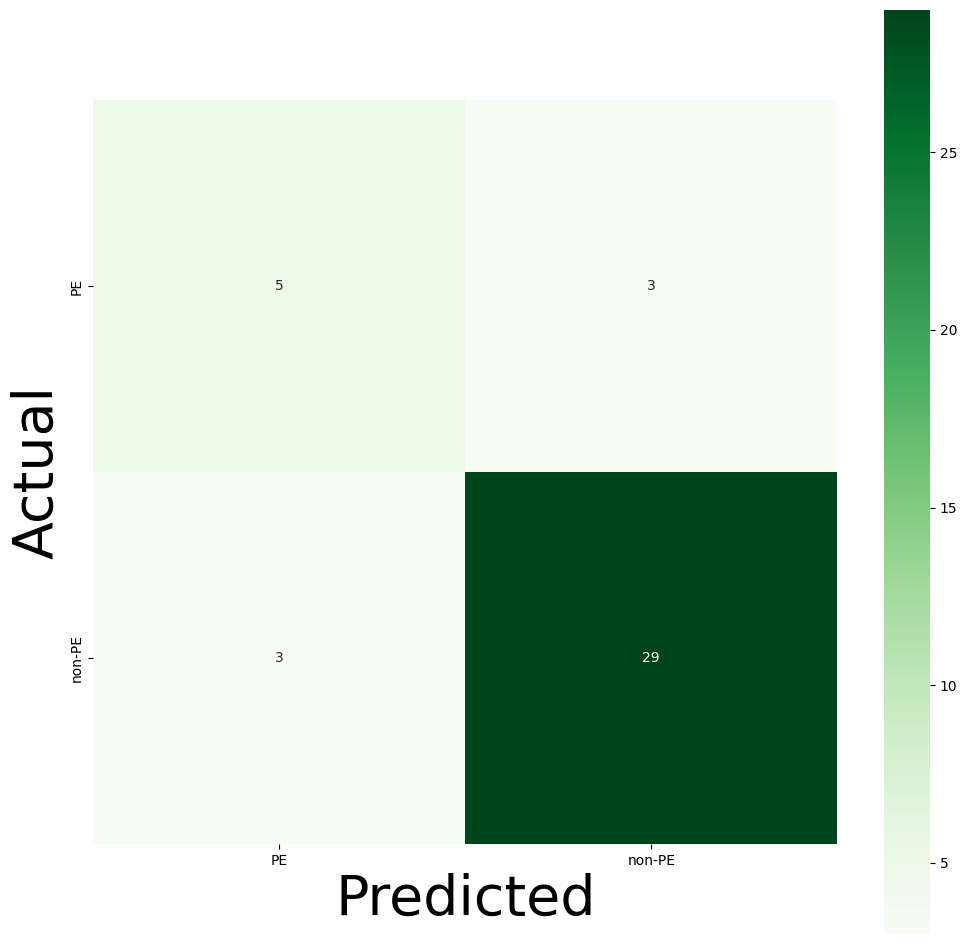

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Y_pred = model.predict(x_val)
disease_types=['PE', 'non-PE']



#Y_pred = np.argmax(Y_pred, axis=1)
#Y_true = y_val
#Y_true = np.argmax(y_val,axis=1)
#print (Y_pred)
#print (Y_true)
#cm = confusion_matrix(Y_true, Y_pred)

cm = [[TP,FN],[FP,TN]]

plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

[0.      0.      0.03125 0.03125 0.0625  0.0625  0.09375 0.09375 0.34375
 0.34375 0.375   0.375   0.8125  0.8125  1.     ] [0.    0.125 0.125 0.25  0.25  0.375 0.375 0.625 0.625 0.75  0.75  0.875
 0.875 1.    1.   ] [90.48923349 89.48923349 85.35516262 52.59115696 49.97638464 47.96086252
 43.50582063 40.08763134 20.06203532 19.38856542 19.22688037 18.17338467
  4.81464379  4.39246446  0.33633148]


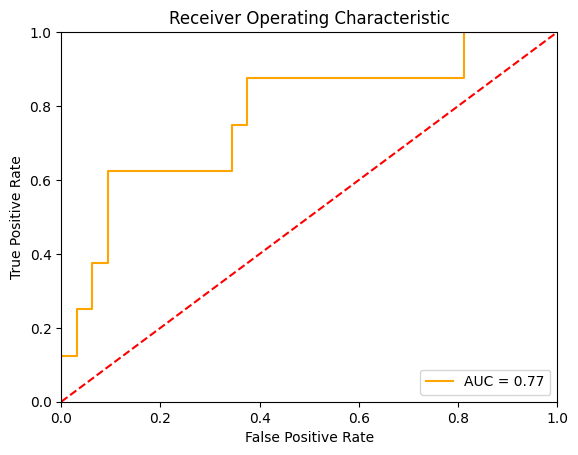

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# 讀取資料
import pandas as pd
#df=pd.read_csv('./AUC.csv')

# 在各種『決策門檻』（decision threshold）下，計算 『真陽率』（True Positive Rate；TPR）與『假陽率』（False Positive Rate；FPR）
fpr, tpr, threshold = roc_curve(df_out2['actual'], df_out2['predict'])
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()  